In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

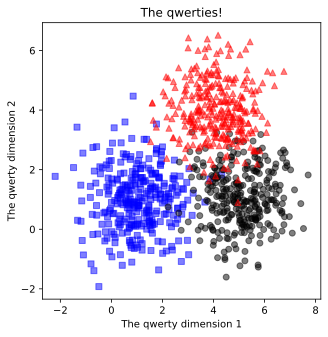

In [2]:
# create data

nPerClust = 300
blur = 1


A = [1,1]
B = [5,1]
C = [4,4]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [ C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.hstack((np.zeros((nPerClust)),
                       np.ones((nPerClust)),
                       1 + np.ones((nPerClust))))
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()


fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels == 0)[0],0], data[np.where(labels == 0)[0],1], 'bs', alpha = .5)
plt.plot(data[np.where(labels == 1)[0],0], data[np.where(labels == 1)[0],1], 'ko', alpha = .5)
plt.plot(data[np.where(labels == 2)[0],0], data[np.where(labels == 2)[0],1], 'r^', alpha = .5)

plt.title('The qwerties!')
plt.xlabel('The qwerty dimension 1')
plt.ylabel('The qwerty dimension 2')
plt.show()

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2)

# converting into tensor dataset
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# dataloader
batchsize = 16
train_loader = DataLoader(train_data, batch_size=16, shuffle = True, drop_last= False)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [21]:
# batches info
print(f"There are {len(train_loader) } batches, each with {batchsize} samples. ")

There are 45 batches, each with 16 samples. 


In [26]:
def createQwertyNet():

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(2,8)

            # hidden layer
            self.fc1 = nn.Linear(8,8)
            self.relu1 = nn.ReLU()

            # output layer
            self.output = nn.Linear(8,3)

        # forward pass
        def forward(self,X):

            # relu using `nn.functional` which is same as `torch.relu`
            X = F.relu(self.input(X))

            # creating an instance and using relu with `nn.ReLU`
            X = self.relu1(self.fc1(X))
            return self.output(X)
        

    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)


    return net, lossfun, optimizer


        


In [28]:
# test the model with fake input
net, lossf, opt = createQwertyNet()
print(net)

# input
input=(torch.rand(10,2))
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu1): ReLU()
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[ 0.0571, -0.0342, -0.1232],
        [ 0.0652, -0.0184, -0.1338],
        [ 0.0542, -0.0286, -0.1278],
        [ 0.0606, -0.0252, -0.1310],
        [ 0.0454,  0.0126, -0.1370],
        [ 0.0515, -0.0233, -0.1321],
        [ 0.0628, -0.0272, -0.1294],
        [ 0.0594, -0.0262, -0.1301],
        [ 0.0931,  0.0516, -0.1603],
        [ 0.0838,  0.0225, -0.1552]], grad_fn=<AddmmBackward0>)

In [39]:
def function2trainTheModel():

    # number of epochs 
    numepochs = 100

    # create a new model 
    net, lossfun, optimizer = createQwertyNet()

    # initialize loss
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        batchAcc = []
        batchLoss = []
        net.train()
        for X, y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute accuracy
            matches = torch.argmax(yHat, axis = 1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        trainAcc.append(np.mean(batchAcc))

        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat, axis = 1) == y).float()))

    return trainAcc, testAcc, losses, net



In [45]:
trainAcc, testAcc, losses, net = function2trainTheModel()

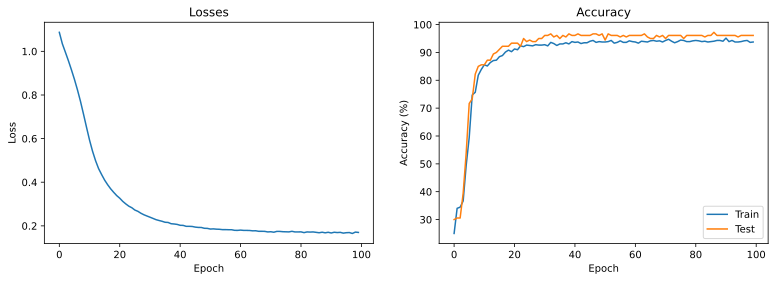

In [46]:
fig, ax = plt.subplots(1,2, figsize = (13,4))
ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

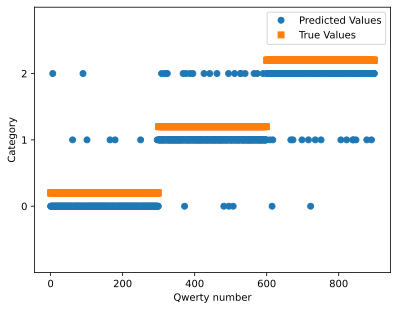

In [47]:
# run the data through the model to get the categorical predictions
yHat = net(data)
predictions = torch.argmax(yHat, axis = 1)

# and plot those against the real data
plt.plot(predictions, 'o', label = 'Predicted Values')
plt.plot(labels+.2, 's', label = 'True Values')
plt.xlabel('Qwerty number')
plt.ylabel('Category')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

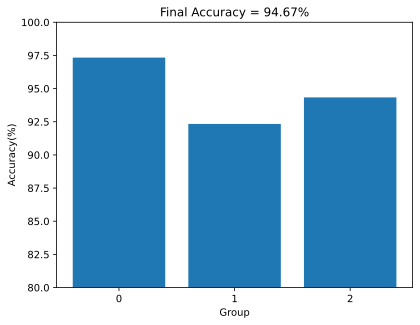

In [48]:
accuracy = (predictions == labels).float()

totalAcc = torch.mean(100*accuracy).item()

# and average by group
accuracyByGroup = np.zeros(3)
for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels == i])

plt.bar(range(3), accuracyByGroup)
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy(%)')
plt.title(f"Final Accuracy = {totalAcc:.2f}%")
plt.show()

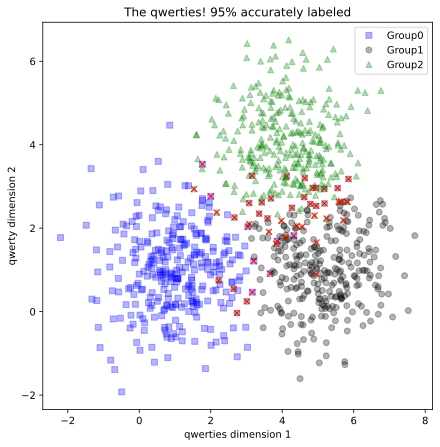

In [49]:
colorShapes = ['bs','ko','g^']

# show the data
fig = plt.figure(figsize = (7,7))

# plot correct and in correct labelled data
for i in range(3):
    plt.plot(data[labels == i,0], data[labels == i,1], 
             colorShapes[i], alpha = .3, label = f'Group{i}')
    
    # crossout the incorrect ones
    idxErr = (accuracy == 0)&(labels == i)
    plt.plot(data[idxErr, 0], data[idxErr, 1], 'rx')

plt.title(f'The qwerties! {totalAcc:.0f}% accurately labeled')
plt.xlabel('qwerties dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

